<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Vera C. Rubin Observatory Logo"> 
<h1 style="margin-top: 10px">Introduction to the Citizen Science Pipeline and Sending Images to Zooniverse</h1>
Authors: Becky Nevin, Clare Higgs, and Eric Rosas <br>
Contact author: Clare Higgs <br>
Last verified to run: 2024-03-21 <br>
LSST Science Pipelines version: Weekly 2024_04 <br>
Container size: small or medium <br>
Targeted learning level: beginner 

<b>Description:</b> This notebook guides a PI through the process of sending data from the Rubin Science Platform (RSP) to the Zooniverse and retrieving classifications from Zooniverse. <br><br>
<b>Skills:</b> Table access protocol (TAP) query, Butler query, create and display cutout images, send cutout images to Zooniverse<br><br>
<b>LSST Data Products:</b> deepCoadd images, manifest file<br><br>
<b>Packages:</b> rubin.citsci, utils (citsci plotting and display utilities) <br><br>
<b>Credit:</b> The TAP query is based on notebooks developed by Leanne Guy and the Butler query is based on notebooks developed by Alex Drlica-Wagner and Melissa Graham<br><br>
<b>Get Support: </b>PIs new to DP0 are encouraged to find documentation and resources at <a href="https://dp0-2.lsst.io/">dp0-2.lsst.io</a>. Support for this notebook is available and questions are welcome at cscience@lsst.org.

## Table of Contents
* [1. Introduction](#first-bullet)
* [1.1 Package imports](#second-bullet)
* [1.2 Define functions and parameters](#third-bullet)
* [2. Make a subject set to send to Zooniverse](#fourth-bullet)
* [3. Create a manifest file](#fifth-bullet)
* [4. Send the data to Zooniverse](#sixth-bullet)
* [5. Retrieve the data](#seventh-bullet)

## 1. Introduction <a class="anchor" id="first-bullet"></a>
This notebook provides an introduction to how to use the rubin.citsci package to create cutout images and a manifest file, and send both of these to Zooniverse.

This notebook will restrict the number of object sent to the Zooniverse to 100 objects. This limit is intended to demonstrate a project prior to full approval from the education and public outreach (EPO) Data Rights Panel.

### 1.1 Package imports <a class="anchor" id="second-bullet"></a>

#### Install Pipeline Package

First, install the Rubin Citizen Science Pipeline package by doing the following:

1. Open up a New Launcher tab
2. In the "Other" section of the New Launcher tab, click "Terminal"
3. Use `pip` to install the `rubin.citsci` package by entering the following command:
```
pip install rubin.citsci
```
Note that this package will soon be installed directly on RSP.

4. Confirm the next cell containing `from rubin.citsci import pipeline` works as expected and does not throw an error

In [1]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
from rubin.citsci import pipeline
# import utils_main_2 as utils
import utils2 as utils
plt.style.use('tableau-colorblind10')

### 1.2 Define functions and parameters <a class="anchor" id="third-bullet"></a>
First, [create a Zooniverse account](https://www.zooniverse.org/accounts/registerhttps://www.zooniverse.org/accounts/register) and create your Zooniverse project.

IMPORTANT: Your Zooniverse project must be set to "public", a "private" project will not work. Select this setting under the "Visibility" tab, (it does not need to be set to live). 

Supply the email associated with your Zooniverse account and project slug below. 

A "slug" is the string of your Zooniverse username and your project name without the leading forward slash, for instance: "username/project-name". [Click here for more details](https://www.zooniverse.org/talk/18/967061?comment=1898157&page=1).


In [2]:
email = "erosas@lsst.org"
slug_name = "ericrosas/test-project"
os.environ["CITSCI_PIPELINE_DEV_MODE"] = "1"
print("Loading and running utilities to establish a link with Zooniverse")
print("Enter your Zooniverse username followed by password below")
cit_sci_pipeline = pipeline.CitSciPipeline()
cit_sci_pipeline.login_to_zooniverse(slug_name, email)

Loading and running utilities to establish a link with Zooniverse
Enter your Zooniverse username followed by password below
Development mode enabled.
WARNING! : You currently have v0.4.3 of this package installed, but v0.5.0 is available.
To install the latest version, open up a terminal tab and run the following command:
    pip install --upgrade --force-reinstall rubin.citsci
After the upgrade installation has finished, please restart the kernel for the changes to take effect.
Enter your Zooniverse credentials...


Username:  ericrosas
 ········


You now are logged in to the Zooniverse platform.


## 2. Make a subject set to send to Zooniverse <a class="anchor" id="fourth-bullet"></a>
A subject set is a collection of data (images, plots, etc) that are shown to citizen scientists. It is also the unit of data that is sent to Zooniverse.

This notebook curates a subject set of objects to send to Zooniverse. This can be modified to create your own subject set. Your subject set must have 100 objects or less in the testing phase before your project is approved by the EPO Data Rights panel. 

This example makes a set of image cutouts of galaxies.

In [3]:
# print('Establishing the connection to the Butler')
# config = "dp02"
# collection = "2.2i/runs/DP0.2"
# service, butler, skymap = utils.setup_butler(config, collection, with_concurrency=True)
# # service, butler, skymap = utils.setup_butler(config, collection)
# print('Connected')

Establishing the connection to the Butler
Connected


In [3]:
##### print('Setting the parameters for making image cutouts')
number_sources = 4  # change this to 100 for a full subject set test
# use_center_coords = "62, -37"
ra = 62
dec = -37
use_radius = "1.0"
radius = 1.0

This query can be modified to select other types of sources.

For more details, please have a look at the RSP tutorial notebooks (`/home/your_username/notebooks/tutorial-notebooks`).

In [4]:
print('Running the Butler query to return objects')
# results = utils.run_butler_query(service, number_sources, use_center_coords, use_radius)

from astropy.coordinates import SkyCoord
from astropy import units as u
from lsst.geom import SpherePoint
import lsst.geom as geom
from lsst.rsp import get_tap_service
service = get_tap_service("tap")

# ra = 55.7467
# dec = -32.2862


coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
# radius = .1 * u.deg
# radius = 1.0

spherePoint = SpherePoint(ra*geom.degrees, dec*geom.degrees)

query = "SELECT s_ra, s_dec, lsst_patch, lsst_tract, s_region " + \
        "FROM ivoa.ObsCore " + \
        "WHERE dataproduct_type = 'image' " + \
        "AND obs_collection = 'LSST.DP02' " + \
        "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
        "AND CONTAINS(POINT('ICRS', " + str(coord.ra.value) + \
        ", " + str(coord.dec.value) + "), " + \
        "s_region) = 1"

results = service.search(query)

tract = results['lsst_tract'][0]
patch = results['lsst_patch'][0]

# print(tract)
# print(patch)

results

Running the Butler query to return objects


<DALResultsTable length=12>
       s_ra        ...
       deg         ...
     float64       ...
------------------ ...
62.131944865908196 ...
62.131944865908196 ...
62.131944865908196 ...
62.131944865908196 ...
62.131944865908196 ...
62.131944865908196 ...
 62.13194496499275 ...
 62.13194496499275 ...
 62.13194496499275 ...
 62.13194496499275 ...
 62.13194496499275 ...
 62.13194496499275 ...

In [6]:
# print('Preparing the table')
# results_table = utils.prep_table(results, skymap)

Preparing the table


Have a look at the table you'll use to save the cutout images.

In [7]:
# results_table
# for index, row in results_table.iterrows():
#     print(row["dataId"])
#     break

{'band': 'i', 'tract': 3637, 'patch': 44}


## 3. Create a manifest file <a class="anchor" id="fifth-bullet"></a>

In [5]:
print('Specify the directory that the cutouts will be output to')
batch_dir = "./cutouts/"
print(f"Make the manifest file and save both the manifest and the cutout images in this folder: {batch_dir}")
# manifest = utils.make_manifest_with_images(results_table, butler, batch_dir)
query = "SELECT access_format, access_url, dataproduct_subtype, " + \
    "lsst_patch, lsst_tract, lsst_band, s_ra, s_dec  " + \
    "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
    "AND obs_collection = 'LSST.DP02' " + \
    "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
    "AND lsst_tract = " + str(tract) + " " + \
    "AND lsst_patch = " + str(patch) + " " + \
    "AND lsst_band = 'i' "

results = service.search(query)
results.to_table().show_in_notebook()

Specify the directory that the cutouts will be output to
Make the manifest file and save both the manifest and the cutout images in this folder: ./cutouts/


idx,access_format,access_url,dataproduct_subtype,lsst_patch,lsst_tract,lsst_band,s_ra,s_dec
,,,,,,,deg,deg
0,application/x-votable+xml;content=datalink,https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/e9dbe2e4-b1e1-450e-b430-3f31e7a293f8,lsst.deepCoadd_calexp,3,3831,i,62.131944865908196,-37.11010890145222


Have a look at some of the cutout images. 

The following cell will plot all images from the `batch_dir` preceded by their image names. The axes are pixel values, with ranges according to your preset radius. These are large co-added images centered on different coordinates; they contain many galaxies and stars.

In [6]:
# for file in os.listdir(batch_dir):
#     try:
#         plt.title(file)
#         image = mpimg.imread(batch_dir + file)
#         plt.imshow(image)
#         plt.axis('off')
#         # plt.show()
#     except:
#         continue

query = "SELECT access_format, access_url, dataproduct_subtype, " + \
    "lsst_patch, lsst_tract, lsst_band, s_ra, s_dec  " + \
    "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
    "AND obs_collection = 'LSST.DP02' " + \
    "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
    "AND lsst_tract = " + str(tract) + " " + \
    "AND lsst_patch = " + str(patch) + " " + \
    "AND lsst_band = 'i' "

results = service.search(query)
results.to_table().show_in_notebook()

idx,access_format,access_url,dataproduct_subtype,lsst_patch,lsst_tract,lsst_band,s_ra,s_dec
,,,,,,,deg,deg
0,application/x-votable+xml;content=datalink,https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/e9dbe2e4-b1e1-450e-b430-3f31e7a293f8,lsst.deepCoadd_calexp,3,3831,i,62.131944865908196,-37.11010890145222


In [7]:
from pyvo.dal.adhoc import DatalinkResults, SodaQuery
dataLinkUrl = results[0].getdataurl()
auth_session = service._session
dl_results = DatalinkResults.from_result_url(dataLinkUrl,
                                             session=auth_session)

f"Datalink status: {dl_results.status}. Datalink service url: {dataLinkUrl}"

"Datalink status: ('OK', 'QUERY_STATUS not specified'). Datalink service url: https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/e9dbe2e4-b1e1-450e-b430-3f31e7a293f8"

In [8]:
sq = SodaQuery.from_resource(dl_results,
                             dl_results.get_adhocservice_by_id("cutout-sync"),
                             session=auth_session)
sq

{'ID': 'butler://dp02/e9dbe2e4-b1e1-450e-b430-3f31e7a293f8'}

## 

In [9]:
from lsst.afw.image import ExposureF
from astropy.io import fits

# sphereRadius = 0.05 * u.deg
sphereRadius = 1.0

sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
             spherePoint.getDec().asDegrees() * u.deg,
             sphereRadius)

# first write the file to disk:
cutout_path = f'{batch_dir}soda-cutout-circle.fits'
# with open(cutout_path, 'bw') as f:
#     f.write(sq.execute_stream().read())
image = sq.execute_stream().read()

## What the cutout _should_ look like
The downside is that this method directly uses the leaky lsst.display.afw module

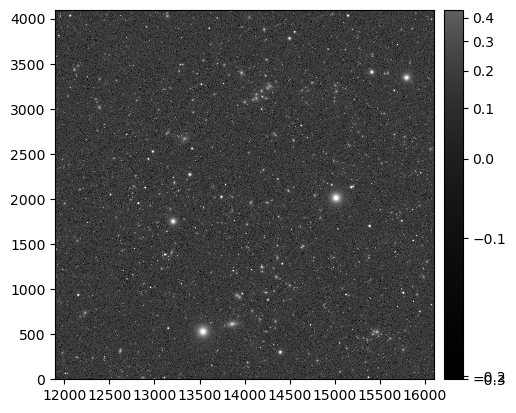

In [10]:
import lsst.afw.display as afwDisplay
exp = ExposureF(cutout_path)
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(exp.image)
plt.show()

## The purely Matplotlib way (not thread safe)

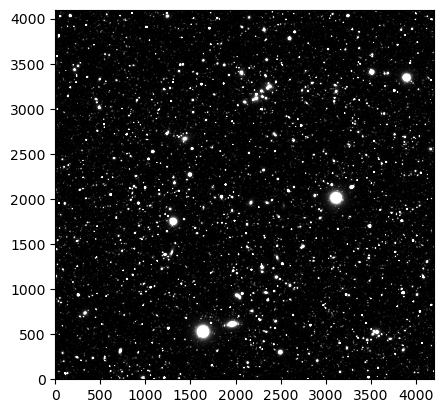

In [13]:
img_data = fits.getdata(cutout_path)
plt.imshow(img_data, cmap='gray',vmin=0, vmax=0.7, norm='linear',origin='lower')
plt.savefig('test.png')

## The Pillow (PIL) way
This method uses neither Matplotlib nor lsst.display.afw, but may not be thread safe

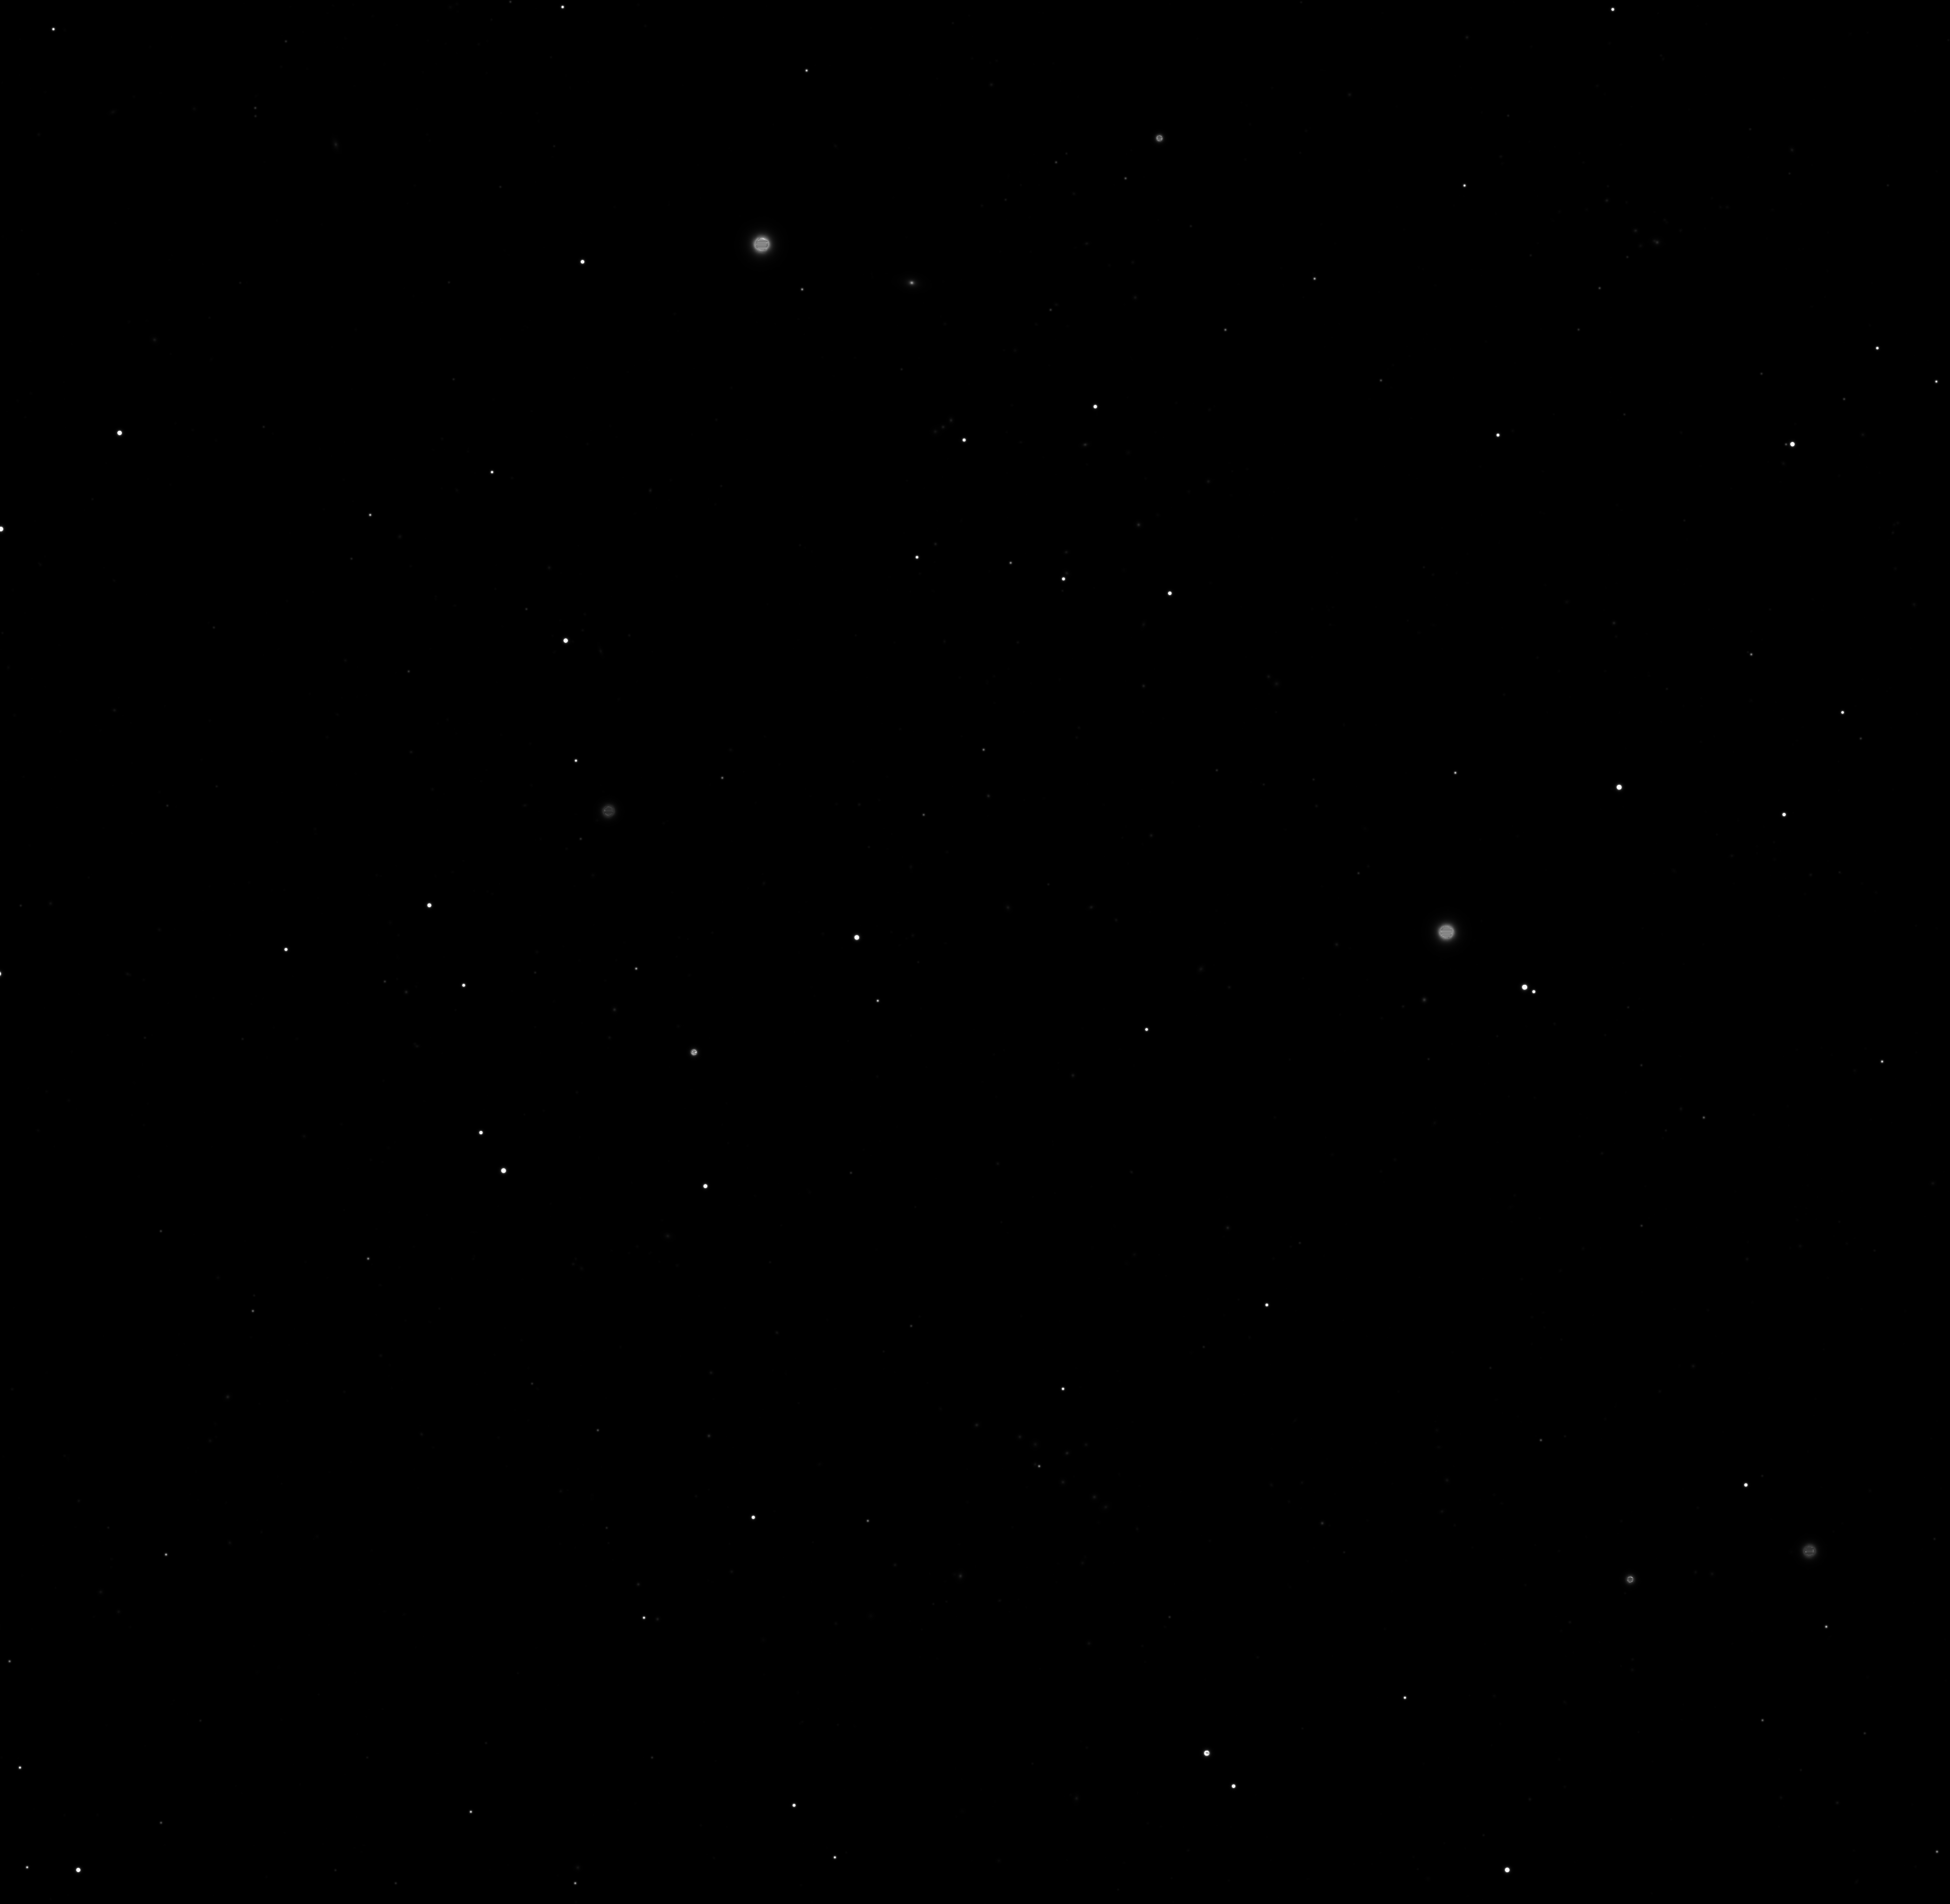

In [12]:
from PIL import Image
import numpy as np
from IPython.display import display
# from IPython.display import Image
# pil_img = Image(filename='data/empire.jpg')
# display(pil_img)

fits_file = fits.open(cutout_path)
pixel_array = fits_file[1].data

# # Use PIL to create an image from the new array of pixels
new_image = Image.fromarray(pixel_array.astype(np.float64))
new_image = new_image.convert('L')
new_image.save('new.png')
display(new_image)

## The `astropy.vizualizations` way

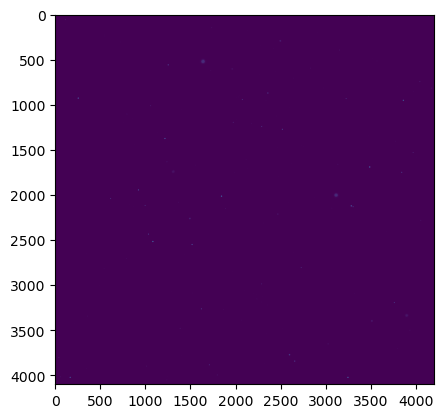

In [13]:
import astropy.visualization as aviz
norm = aviz.ImageNormalize(stretch=aviz.AsinhStretch(0.5))
scaled = norm(pixel_array)
# scaled
# display(scaled)
plt.imshow(scaled)

There are multiple options for how to create the manifest file.
### 3.1 Option 1: Write the manifest file to the filesystem automatically
The below cell writes the `manifest.csv` file to the filesystem, which will be used by Zooniverse. This is the recommended option for PIs new to the citizen science pipeline.

In [ ]:
manifest_path = cit_sci_pipeline.write_manifest_file(manifest, batch_dir)
print("The manifest CSV file can be found at the following relative path:")
print(manifest_path)

### 3.2 Option 2: Make your own manifest file

PIs are welcome to create their own manifest file. This is not the recommended option for PIs new to the citizen science pipeline.

The manifest file _must_ abide by [RFC4180](https://datatracker.ietf.org/doc/html/rfc4180.html) as the backend service that parses the manifest file expects this format. In addition, you may have a column with no values, but there _must_ be an empty column value indicated with a comma. For example:

Valid syntax for empty column:
```
column1,column2,empty_column,column4
1,1,,4
1,1,,4
1,1,,4
```

**Important**: The manifest file must be named `manifest.csv` in order for the processing on the backend to work correctly.

## 4. Send the data to Zooniverse <a class="anchor" id="sixth-bullet"></a>
Zip up the data and send it to the Zooniverse.

#### 4.1 Zip up the data
Running the below cell will zip up all the cutouts into a single file - this can take 5 to 10 minutes for large data sets (> 5k cutouts).

In [ ]:
zip_path = cit_sci_pipeline.zip_image_cutouts(batch_dir)

#### 4.2 Send image data

This cell will let PIs send one subject set. Name the subject set as it will appear on Zooniverse.

Running this cell will also initiate the data transfer and make your data available on the Zooniverse platform.

In [ ]:
subject_set_name = "manifest refactor test - 5"
cit_sci_pipeline.send_image_data(subject_set_name, zip_path)

## 5. Retrieve the classification data from Zooniverse <a class="anchor" id="seventh-bullet"></a>
There are two ways to do this:

1) Go to your Zooniverse project and downloading the output csv files found on the 'Data Exports' tab. Click the 'Request new classification report' button and per Zooniverse: "Please note some exports may take a long time to process. We will email you when they are ready. You can only request one of each type of data export within a 24-hour time period."

2) Programatically (as demonstrated below). There are two ways to do this.

Find the `project_id` on Zooniverse by selecting 'build a project' and then selecting the project. Note that you don't need to be the project owner.

In [ ]:
print('Retrieve the classifications from Zooniverse')
project_id = 19539
raw_clas_data = cit_sci_pipeline.retrieve_data(project_id)

counter = 0
list_rows = []

If the following cell throws an error, restart the kernel and rerun the cell.